In [1]:
import torch
from torch.nn import NLLLoss
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.backends.cudnn as cudnn

%matplotlib inline
import pylab as pl
from IPython import display
import time

from helpful_files.networks import Network, predict
from helpful_files.training import *
from helpful_files.testing import *

from KiTS_dataset import KiTS_Set

In [2]:
# Set Important Values

# General settings
datapath = './'                     # The location of your train, test, repr, and query folders. Make sure it ends in '/'!
savepath = 'myModel.pth'            # Where should your trained model(s) be saved, and under what name?
gpu = 0                             # What gpu do you wish to train on?
workers = 6                         # Number of cpu worker processes to use for data loading
epoch = 10                          # Number of passes over the dataset before the learning rate is cut
ncuts = 5                           # Number of times to cut the learning rate before training completes
verbosity = 5                       # How many batches in between status updates 
ensemble = 3                        # How many models to train in parallel
k = 1                               # Evaluate top-k accuracy. Typically 1 or 5. 
torch.cuda.set_device(gpu)
cudnn.benchmark = True
trn_pct = 0.9                       #test/val split pct

# Batch construction
way = 4                            # Number of classes per batch during training
trainshot = 2                       # Number of images per class used to form prototypes
testshot = 1                       # Number of images per class used to make predictions

num_classes = 6                    #for validation

# Model construction
folding = True                      # Use batch folding?
covariance_pooling = True           # Use covariance pooling?
localizing = True                   # Use localization?
fewshot_local = False                # If you are using localization: few-shot, or parametric? Few-shot if True, param if False
network_width = 32                  # Number of channels at every layer of the network

# Data loading
augmentation_flipping = True        # Horizontal flip data augmentation
include_masks = (localizing         # Include or ignore the bounding box annotations?
                 and fewshot_local)
data_shape = (128,128,128)


# Calculate embedding size based on model setup
d = (network_width if not 
     covariance_pooling else
     network_width**2)
if localizing and not covariance_pooling:
    d = network_width*2

In [3]:
# Load Training Data 
#this step takes forever 
#sampler has to iterate through whole dataset and dataset is real big


"""
d_boxes = torch.load('helpful_files/box_coords.pth')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4905, 0.4961, 0.4330],std=[0.1737, 0.1713, 0.1779])
    ])
"""
if folding:
    # Batch folding has no reference/query distinction
    shots = [trainshot+testshot]
else:
    # Standard setup
    shots = [trainshot, testshot]
if localizing and fewshot_local and not folding:
    # Unfolded prototype localizers need another set of reference images to inform foreground/background predictions
    shots = [trainshot, trainshot, testshot-trainshot]
    
"""
train_dataset = datasets.ImageFolder(
    datapath+'train', 
    loader = lambda x: load_transform(x, d_boxes, transform, augmentation_flipping, include_masks))
"""
trainset = KiTS_Set(data_shape)

train_data,val_data = torch.utils.data.random_split(trainset,[round(trn_pct*len(trainset)), round((1-trn_pct)*len(trainset))])

train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_sampler = ProtoSampler(train_data, way, shots),
    num_workers = workers,
    pin_memory = True)

val_repr_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_sampler = OrderedSampler(train_data, shots[-1]),
    num_workers = workers,
    pin_memory = True)

val_loader = torch.utils.data.DataLoader(
    val_data, 
    batch_sampler = OrderedSampler(val_data, shots[-1]), #batch size must be equal to shots
    #batch_size = 3,
    num_workers = workers,
    #drop_last = True,
    #shuffle = True,
    pin_memory = True)

print('Data loaded!')

100%|██████████| 21/21 [06:53<00:00, 19.71s/it]

Data loaded!


In [4]:
# Make Models

models = [Network(network_width, folding, covariance_pooling, 
                  localizing, fewshot_local, shots).cuda() 
          for i in range(ensemble)]
optimizer = [optim.Adam(m.parameters(), lr=.0001) for m in models]
scheduler = [optim.lr_scheduler.LambdaLR(o, lambda x: 1/(2**x)) for o in optimizer]
criterion = NLLLoss().cuda()

"""
expander = avgpool()
if localizing:
    if fewshot_local:
        expander = fsCL if covariance_pooling else fsL
    else:
        expander = pCL() if covariance_pooling else pL()
elif covariance_pooling:
    expander = covapool
expanders = [expander for _ in range(ensemble)]


if localizing and not fewshot_local:
    fbcentroids = torch.load(model[:model.rfind('.')]+'_localizers'+model[model.rfind('.'):])
    for i in range(ensemble):
        expanders[i].centroids.data = fbcentroids[i]
        expanders[i].cuda()
"""

nweights = sum([i.numel() for i in list(models[0].parameters())])
print(nweights,"parameters in each neural net.")
print('Ready to go!')

140388 parameters in each neural net.
Ready to go!


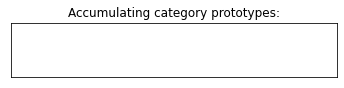

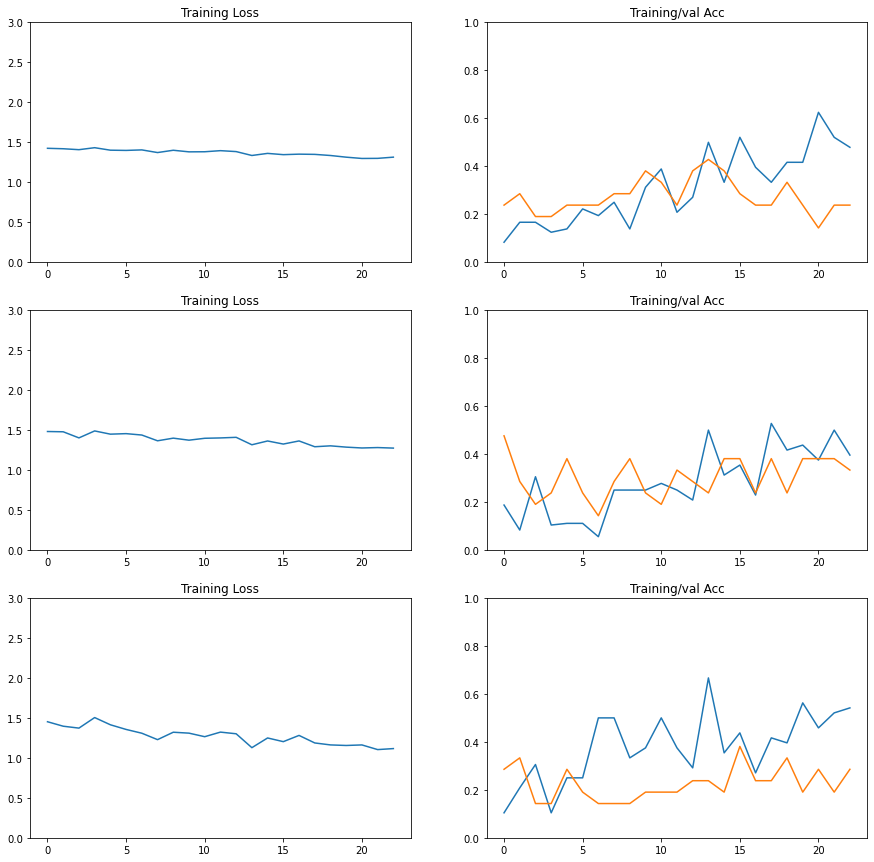

Training loss is: [1.3143129348754883, 1.2748411893844604, 1.1159670799970627]
Training accuracy is: [0.47916666666666663, 0.39583333333333337, 0.5416666666666666]

Validation accuracy is: [0.23809523809523808, 0.3333333333333333, 0.2857142857142857]

Approximately 13.52 hours to completion

Training images covered this round:


KeyboardInterrupt: 

In [5]:
# Do the Thing!

start = time.time()
trainlosses, acctracker = [[] for _ in range(ensemble)],[[] for _ in range(ensemble)]
valacctracker = [[] for _ in range(ensemble)]
num_classes = 6

epochs = ncuts*epoch
for e in range(epochs):
    
    
    # Train for one epoch
    trainloss, acc = train(train_loader, models, optimizer, criterion, way, shots, verbosity)
    
    # Update the losses
    display.clear_output(wait=True)
    for j in range(ensemble):
        trainlosses[j].append(trainloss[j])
        acctracker[j].append(acc[j])
    
    
    #now run the validation set
    
    #create necessary vars
    expanders = [m.postprocess for m in models]
    #centroids = [e.centroids for e in expanders]
    fbcentroids = [None]*ensemble
    val_models = [m.encode for m in models]
    acclist = []
    pcacclist = []
    alldispacc = np.zeros(num_classes)
    
    """
    # Accumulate foreground/background prototypes, if using
    fbcentroids = (accumulateFB(models, repr_loader, way, network_width, ngiv, bsize)
                   if include_masks else 
                   [None]*ensemble)
    # Accumulate category prototypes
    centroids, counts = accumulate(models, repr_loader, expanders, 
                                   fbcentroids, way, d)
    
    # Score the models
    allacc, dispacc, perclassacc = score(k, centroids, fbcentroids, models, 
                                         query_loader, expanders, way)
    """
    centroids, counts = accumulate([m.encode for m in models], val_repr_loader, expanders, 
                                   fbcentroids, num_classes, d)
    # Score the models
    allacc, dispacc, perclassacc = score(k, centroids, fbcentroids, val_models, val_loader, expanders, num_classes)
    
    val_acc = allacc
    for j in range(ensemble):
        valacctracker[j].append(val_acc[j])
    #print(allacc,dispacc,perclassacc)
    # Record val statistics
    #acclist = acclist+allacc
    #pcacclist = pcacclist+list(perclassacc)
    #alldispacc += dispacc
    """
    with torch.no_grad():
        nqueries = shots[-1]
        #targ = torch.LongTensor([i//nqueries for i in range(nqueries*way)]).cuda()
        val_acc = [0]*ensemble
        for i, (img, dat, cd_score) in enumerate(val_loader):
            #print(cd_score)
            img = img.float().cuda()
            cd_score = cd_score.cuda()
            print(cd_score)
            #print(img.size(),shots)
            for j in range(ensemble):
                out = predict(models[j].postprocess.centroids,models[j].postprocess(models[j].encode(img),_,__))
                _,bins = torch.max(out,1)
                #print(torch.sum(torch.eq(bins,cd_score)).item())
                print(bins)
                valacc_single = torch.sum(torch.eq(bins,cd_score)).item()/nqueries/way
                print(valacc_single)
                val_acc[j] += valacc_single
        val_acc = [L/(i+1) for L in val_acc]
    
    
    for j in range(ensemble):
        valacctracker[j].append(val_acc[j])
    """
    """
    # Aggregate collected val statistics
    accs = sum(acclist)/ensemble
    pcaccs = sum(pcacclist)/ensemble
    alldispacc = alldispacc
    confs = 1.96*np.sqrt(np.var(acclist)/ensemble)
    pcconfs = 1.96*np.sqrt(np.var(pcacclist)/ensemble)

    # Report val
    print("Accuracies and 95% confidence intervals")
    print("Mean accuracy: \t\t%.2f \t+/- %.2f" % (accs*100, confs*100))
    print("Per-class accuracy: \t%.f \t+/- %.2f" % (pcaccs*100, pcconfs*100))
    """
    
    
    #trn graphs
    pl.figure(1, figsize=(15,15))
    for i in range(ensemble):
        pl.subplot(ensemble,2,2*i+1)
        pl.plot(trainlosses[i])
        pl.ylim((0,3))
        pl.title("Training Loss")
        pl.subplot(ensemble,2,2*i+2)
        pl.plot(acctracker[i])
        pl.plot(valacctracker[i])
        pl.ylim((0,1))
        pl.title("Training/val Acc")
    pl.show()
    print("Training loss is: "+str(trainloss)+
            "\nTraining accuracy is: "+str(acc)+"\n")
    print("Validation accuracy is: "+str(val_acc)+"\n")
    print("Approximately %.2f hours to completion"%(  (time.time()-start)/(e+1)*(epochs-e)/3600  ))
    print()
    
    
    
    
    # Adjust learnrate
    if e%epoch == 0:
        [s.step() for s in scheduler]
    
print("Training complete: %.2f hours total" % ((time.time()-start)/3600)) 

In [ ]:
# Save the model

torch.save([m.encode.cpu().state_dict() for m in models], savepath)

# If using parametric localization, save the extra parameters
if localizing and not fewshot_local:
    torch.save([m.postprocess.centroids.cpu() for m in models], 
               savepath[:savepath.rfind('.')]+'_localizers'+savepath[savepath.rfind('.'):])
print("Models saved!")